## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
import sys
sys.path.append("../") # go to parent dir
from plant_part_agg_eia import *
from plant_parts import plant_parts
pd.options.display.max_columns = None

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing object

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)
start_date=None
end_date=None
freq='AS'

In [7]:
table_compiler = CompileTables(pudl_engine, freq='AS', rolling=True)

In [8]:
self = CompilePlantParts(table_compiler, plant_parts, clobber=True)

In [9]:
plant_parts_df = self.generate_master_unit_list()

beginning the aggregation for generation_eia923
grabbing generation_eia923 from the sqlite db
Converting the dtypes of: generation_eia923
beginning the aggregation for generators_eia860
grabbing generators_eia860 from the sqlite db
Converting the dtypes of: generators_eia860
beginning the aggregation for mcoe
grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
Converting the dtypes of: mcoe
grabbing ownership_eia860 from the sqlite db
Converting the dtypes of: ownership_eia860
grabbing boiler_generator_assn_eia860 from the sqlite db
Converting the dtypes of: boiler_generator_assn_eia860
grabbing generators_entity_eia from the sqlite db
Converting the dtypes of: generators_entity_eia
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_technology
begin aggregation for: plant_prime_mover
begin aggregation for: plant_gen
begin aggregation for: plant_unit
begin aggregation for: plant
grabbing utilities_eia from the sqlite db
Converting the d

### Exploration of Colstrip...
This next section is a temporary exploration of colstrip as an example of how ownership slicing now works and where the nulls in fuel cost data originates.

In [10]:
table_compiler_no_freq = CompileTables(pudl_engine)

In [11]:
frc = table_compiler_no_freq.grab_the_table('fuel_receipts_costs_eia923')
mcoe = table_compiler.grab_the_table('mcoe')
plant_id = 6076 # colstrip

grabbing fuel_receipts_costs_eia923 from the sqlite db
Converting the dtypes of: fuel_receipts_costs_eia923


In [12]:
df = frc
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
#   & (df['utility_id_eia'] == 15298)
  ].head(1)

,plant_id_eia,report_date,contract_type_code,contract_expiration_date,energy_source_code,fuel_type_code_pudl,fuel_group_code,fuel_group_code_simple,mine_id_pudl,supplier_name,fuel_qty_units,heat_content_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,mercury_content_ppm,fuel_cost_per_mmbtu,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_transport_code,natural_gas_delivery_contract_type_code,moisture_content_pct,chlorine_content_ppm
id,,,,,,,,,,,,,,,,,,,,,,
326746,6076,2016-01-01,C,2017-12-01,DFO,oil,petroleum,oil,<NA>,equitable oil,1024.0,5.92,0.0,0.0,0.0,NaN,TR,None,None,None,NaN,NaN


In [13]:
df = mcoe
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
#   & (df['utility_id_eia'] == 15298)
  ].head(1)

,report_date,plant_id_eia,plant_id_pudl,unit_id_pudl,generator_id,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,balancing_authority_code,balancing_authority_name,capacity_factor,capacity_mw,carbon_capture,cofire_fuels,current_planned_operating_date,deliver_power_transgrid,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,fuel_type_count,heat_rate_mmbtu_mwh,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,net_generation_mwh,operational_status,operational_status_code,other_modifications_date,other_planned_modifications,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,retirement_date,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,summer_capacity_mw,summer_estimated_capability_mw,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,total_fuel_cost,total_mmbtu,turbines_inverters_hydrokinetics,turbines_num,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_mw,winter_estimated_capability_mw
170319,2016-01-01,6076,122,1,1,Colstrip,15298,3397,PPL Montana LLC,NWMT,NorthWestern Energy (NWMT),0.524161,358.0,False,False,NaT,<NA>,SUB,None,None,None,None,None,NaN,NaN,coal,1,11.036018,None,45.8831,-106.614,140.0,False,0.95,1648314.0,existing,OP,NaT,False,J,NaT,None,<NA>,NaN,NaN,NaN,NaN,NaN,None,NaT,2022-07-01,NaT,NaT,PG,None,None,None,MT,307.0,NaN,False,False,Conventional Steam Coal,OVER,NaN,1.819082e+07,NaN,<NA>,NaT,False,307.0,NaN


In [14]:
df = plant_parts_df
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
   & (df['utility_id_eia'] == 15298)
  ].head(1)

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,utility_id_eia,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,ownership,plant_id_pudl,plant_name_eia,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6076_sub_2016_plant_prime_fuel_owned_15298,6076,2016-01-01,plant_prime_fuel,NaN,NaN,NaN,SUB,NaN,15298,False,plant,6076_2016_plant_owned_15298,0.64252,591.4,NaN,NaN,coal,10.965585,1986,3337801.5,owned,122,Colstrip,0.0,9.495148e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip SUB


### Investigate Full Cost Nulls

In [15]:
def count_the_unique_plants(df, count_col):
    df = df.astype({'report_date':'datetime64[ns]'})
    df = df.assign(report_year=df.report_date.dt.year)
    return (len(df[(df[count_col].notnull())
                   & (df[count_col] != 0)].
              drop_duplicates(subset=['plant_id_eia','report_year'])))

In [16]:
# these values should be more or less the same, assuming that there isn't a ton of lost records
# we should expect that the number of records in the main fuel table to be the most complete
logger.info('Fuel Table:          ' + str(count_the_unique_plants(frc,'fuel_cost_per_mmbtu')))
logger.info('MCOE Table:          ' + str(count_the_unique_plants(mcoe,'fuel_cost_per_mmbtu')))
logger.info('Master Unit List:    ' + str(count_the_unique_plants(plant_parts_df,'fuel_cost_per_mmbtu')))
logger.info('Generators from MUL: ' + str(count_the_unique_plants(plant_parts_df[plant_parts_df['plant_part'] == 'plant_gen'],'fuel_cost_per_mmbtu')))

Fuel Table:          6461
MCOE Table:          6241
Master Unit List:    6222
Generators from MUL: 6222


In [17]:
plant_parts_df.to_csv('master_unit_list.csv')

In [18]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in plant_parts.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [19]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'ownership'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='black', alpha='0.1', label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


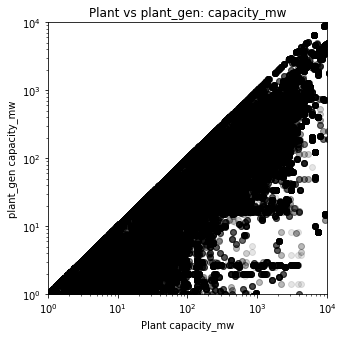

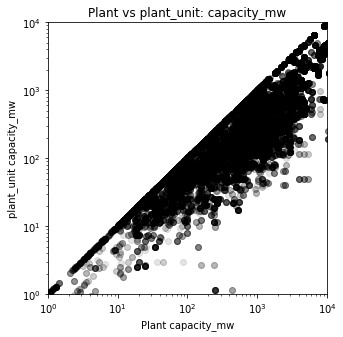

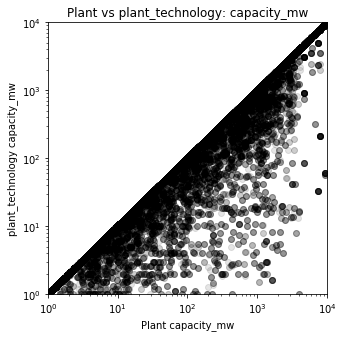

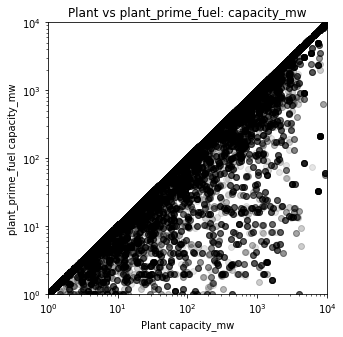

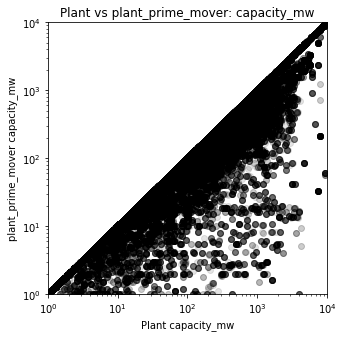

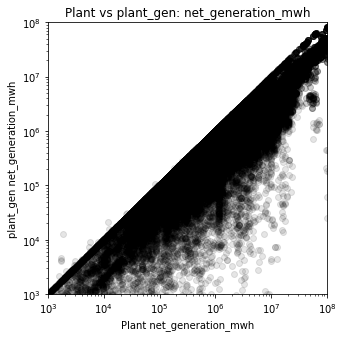

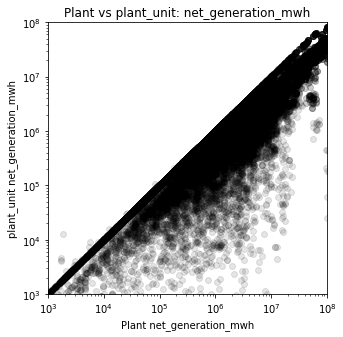

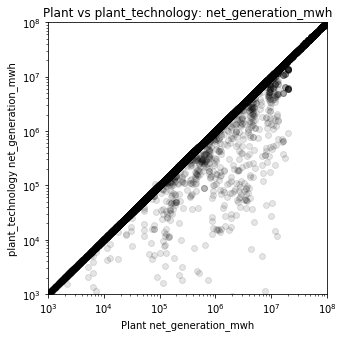

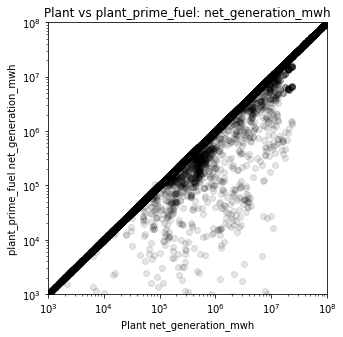

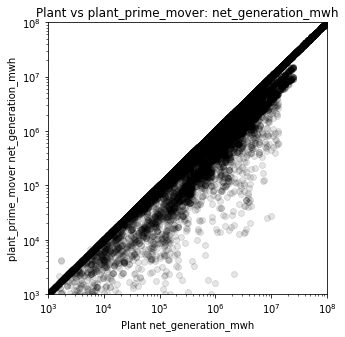

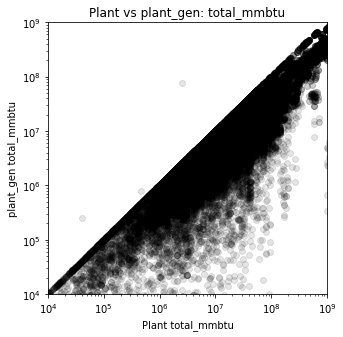

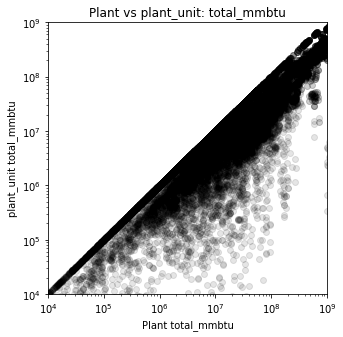

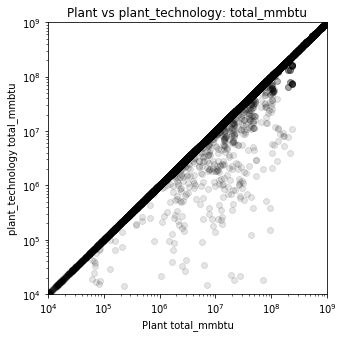

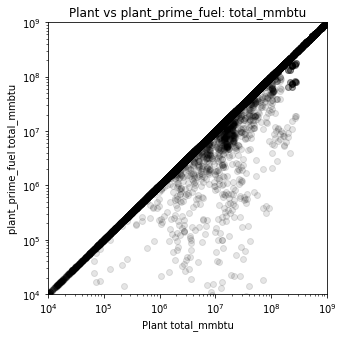

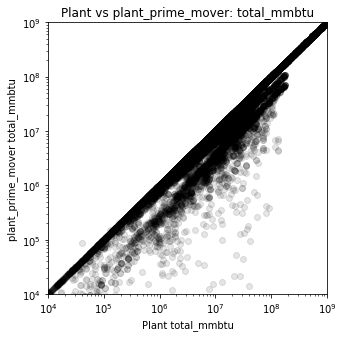

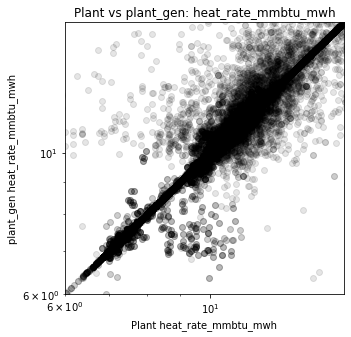

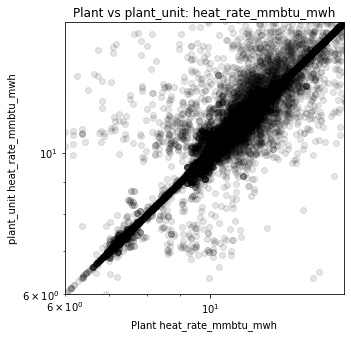

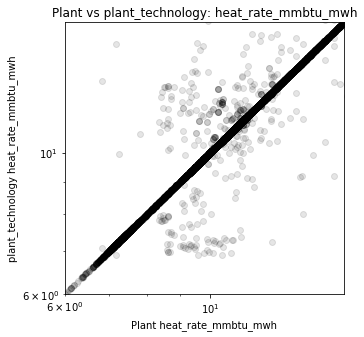

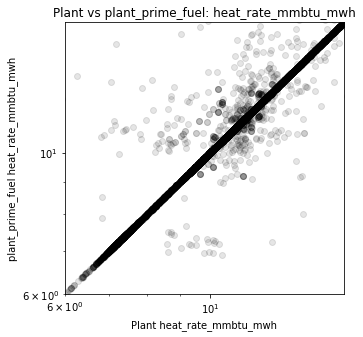

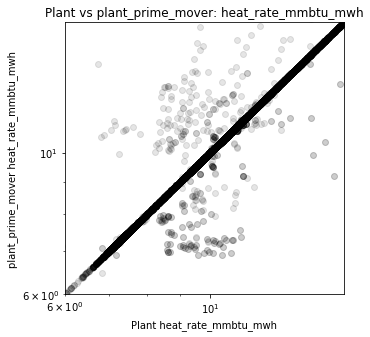

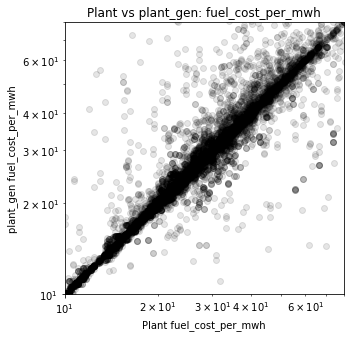

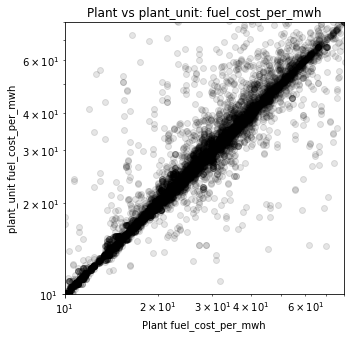

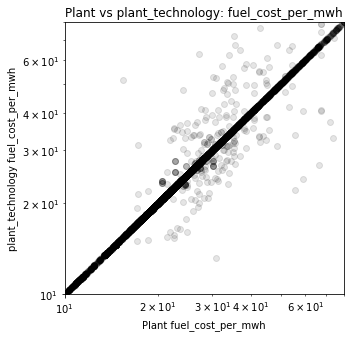

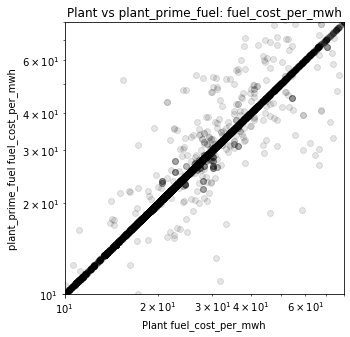

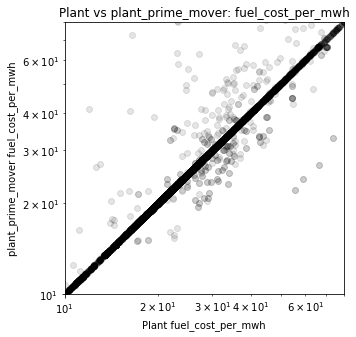

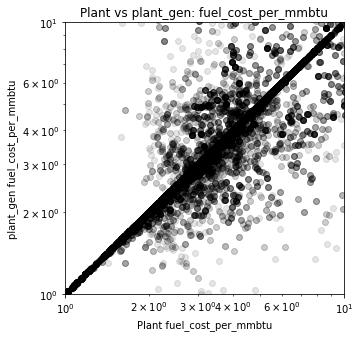

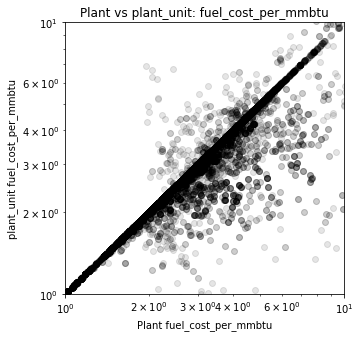

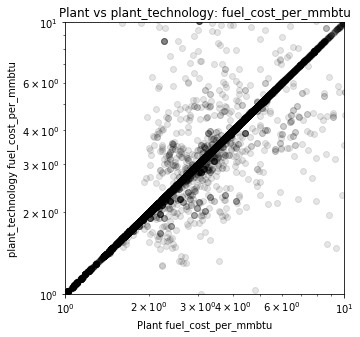

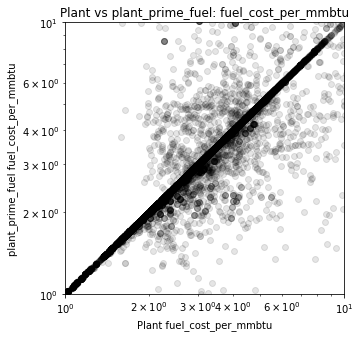

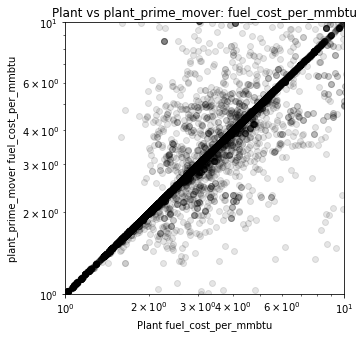

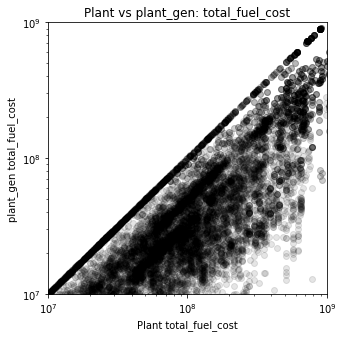

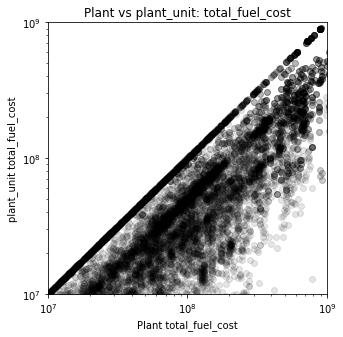

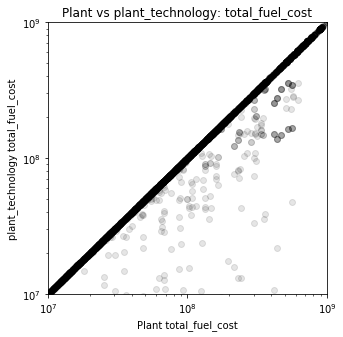

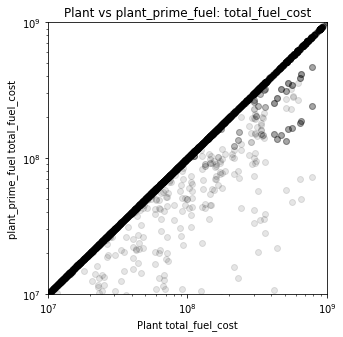

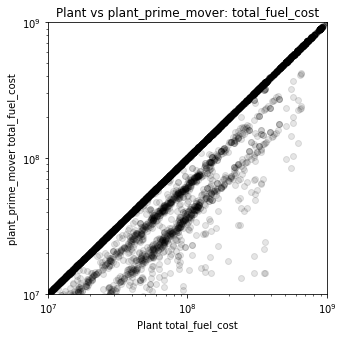

In [20]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    #'opex_fuel',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [21]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="black",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [22]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

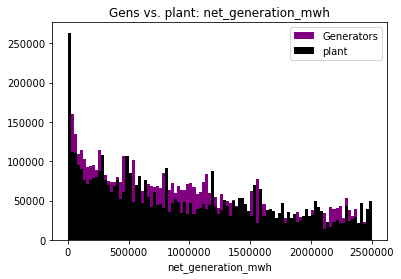

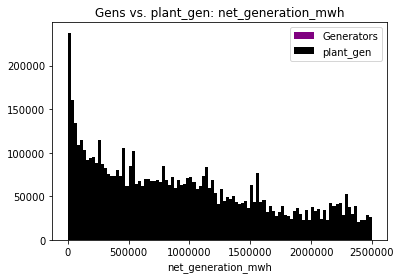

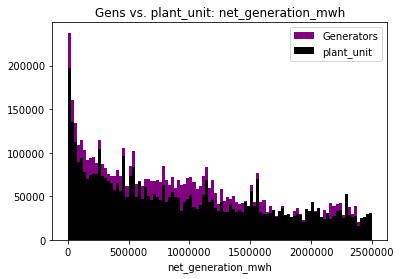

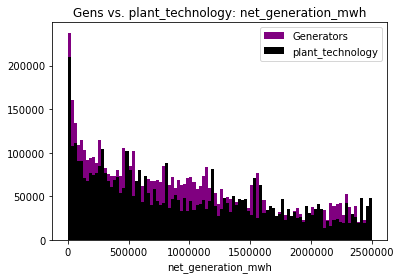

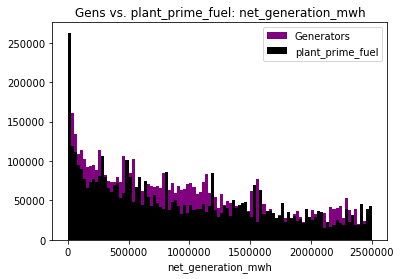

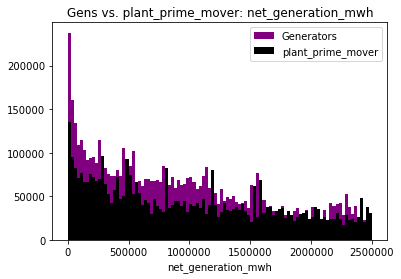

In [23]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

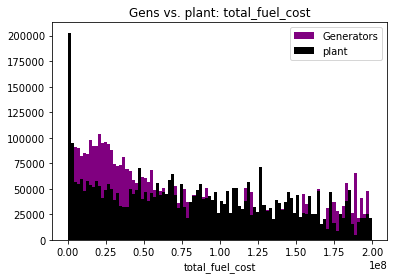

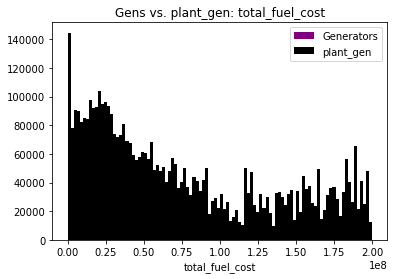

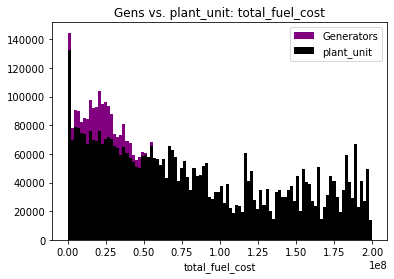

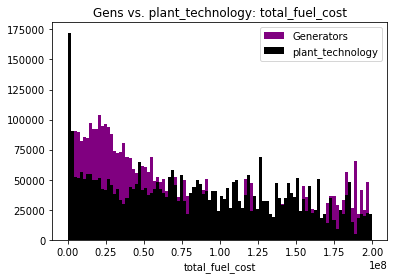

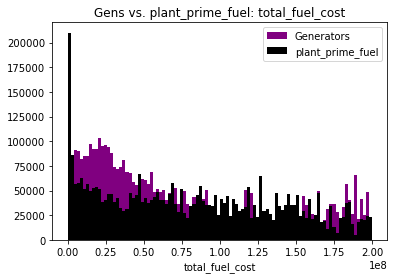

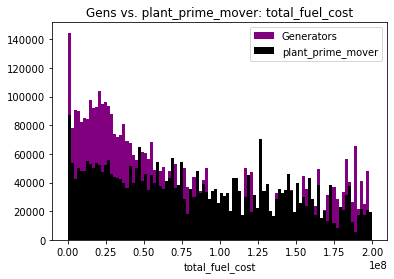

In [24]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


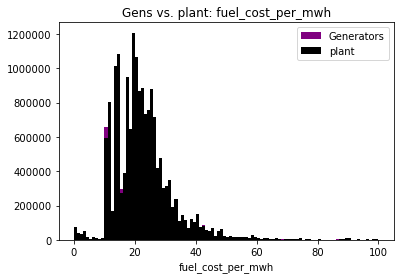

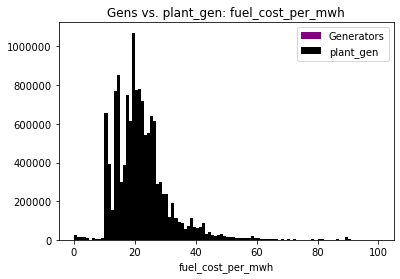

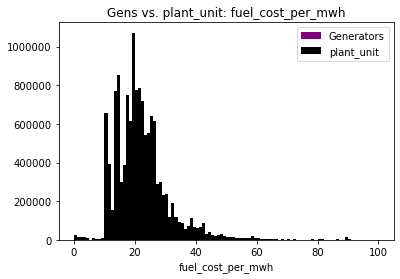

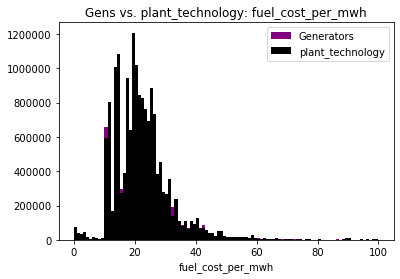

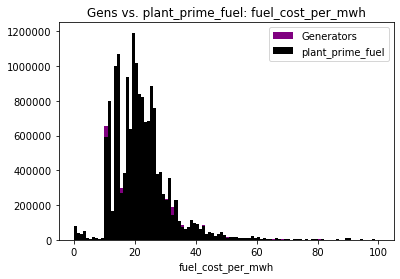

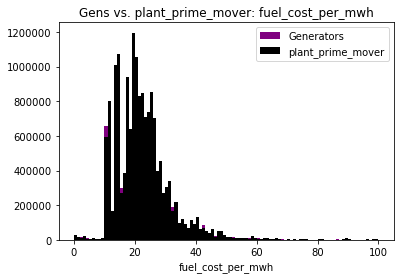

In [25]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

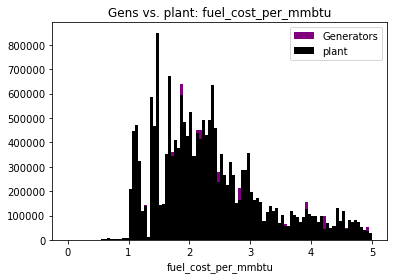

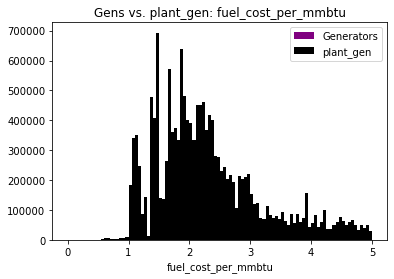

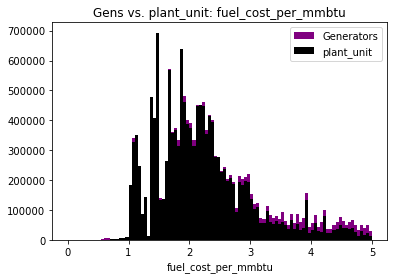

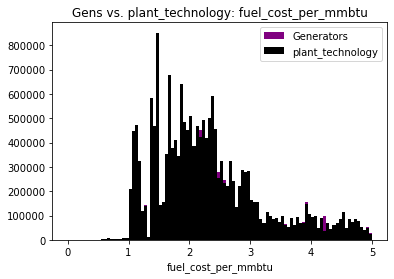

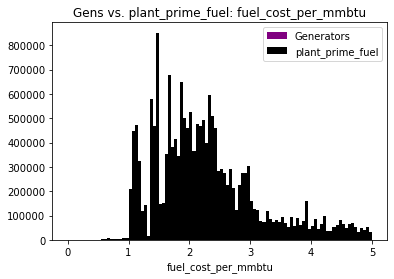

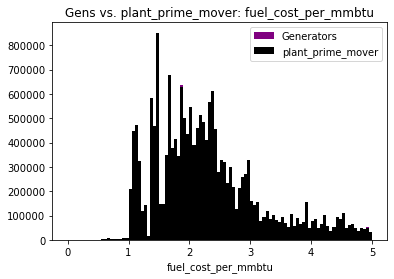

In [26]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [27]:
# various tables to poke at for debuging
generat923 = table_compiler.grab_the_table('generation_eia923')
gens860 = table_compiler.grab_the_table('generators_eia860')
bga860 = table_compiler.grab_the_table('boiler_generator_assn_eia860')
own860 = table_compiler.grab_the_table('ownership_eia860')
plant = compiled_plant_parts['plant']
plant_gen = compiled_plant_parts['plant_gen']
plant_unit = compiled_plant_parts['plant_unit']
plant_fuel = compiled_plant_parts['plant_prime_fuel']
plant_tech = compiled_plant_parts['plant_technology']
plant_pm = compiled_plant_parts['plant_prime_mover']

In [28]:
# this can be used to see if the aggregations generally worked properly
plant_gen_agged = plant_gen.groupby(by=['utility_id_eia','plant_id_eia','ownership','report_date']).sum().reset_index()
merge = plant.merge(plant_gen_agged,
                    on=['utility_id_eia','plant_id_eia','ownership','report_date'],
                    suffixes=('_plant','_gen')).drop(columns=['fuel_cost_per_mmbtu_plant','fuel_cost_per_mmbtu_gen',
                                                              'heat_rate_mmbtu_mwh_plant', 'heat_rate_mmbtu_mwh_gen',
                                                              'fuel_cost_per_mwh_plant','fuel_cost_per_mwh_gen',
                                                             ])

In [29]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)

In [30]:
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,total
plant_id_eia,13259,32272,3285,14541,14259,15137,92753
report_date,13259,32272,3285,14541,14259,15137,92753
plant_part,13259,32272,3285,14541,14259,15137,92753
generator_id,0,32272,0,0,0,0,32272
unit_id_pudl,0,0,3285,0,0,0,3285
prime_mover_code,0,0,0,0,0,15137,15137
energy_source_code_1,0,0,0,0,14259,0,14259
technology_description,0,0,0,14541,0,0,14541
utility_id_eia,13259,32272,3285,14541,14259,15137,92753
true_gran,13259,32272,3285,14541,14259,15137,92753


In [32]:
mcoe = table_compiler._dfs['mcoe']
gen_ent = table_compiler._dfs['generators_entity_eia']
plants_eia = table_compiler._dfs['plants_eia']